In [52]:
# Required packages
import pandas as pd
import numpy as np

# Data modeling and preparation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.metrics import accuracy_score, recall_score, precision_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed
SEED = 42

In [53]:
df = pd.read_csv(r"../datasets/weather_data_target.csv")

In [54]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Dryness
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,0
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,0
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,0
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,0
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,0


In [55]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Dryness
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917,0.044091
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499,0.205305
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000,0.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000,0.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000,0.000000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000,1.000000


In [56]:
X = df.drop(["Dryness"], axis=1)
y = df["Dryness"]

__Targe imbalance__

In [57]:
y.value_counts()

Dryness
0    12618
1      582
Name: count, dtype: int64

In [58]:
categorical_features = X.select_dtypes(include=['object','category']).columns
X = pd.get_dummies(X, columns = categorical_features, drop_first=True)

X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,2,3.5,False,False,True,False,False,True,True,False
1,39.0,96,8.5,71.0,1011.43,7,10.0,False,False,True,True,False,False,True,False
2,30.0,64,7.0,16.0,1018.72,5,5.5,False,False,False,True,False,False,False,True
3,38.0,83,1.5,82.0,1026.25,7,1.0,False,False,False,True,False,False,False,False
4,27.0,74,17.0,66.0,990.67,1,2.5,False,True,False,False,False,True,False,True


__Data Splitting (80/20) to avoid leakage__

In [59]:
# === 3. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [60]:
# === 4. Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
# === 5. SMOTE ===
smote = SMOTE(random_state=SEED)
X_train_upsample, y_train_upsample = smote.fit_resample(X_train_scaled, y_train)

In [62]:
# === 6. Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(random_state=SEED)
}

In [63]:
# === 7. Evaluation Function ===
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    RocCurveDisplay.from_predictions(y_test, y_prob, name=name)
    return roc_auc_score(y_test, y_prob)

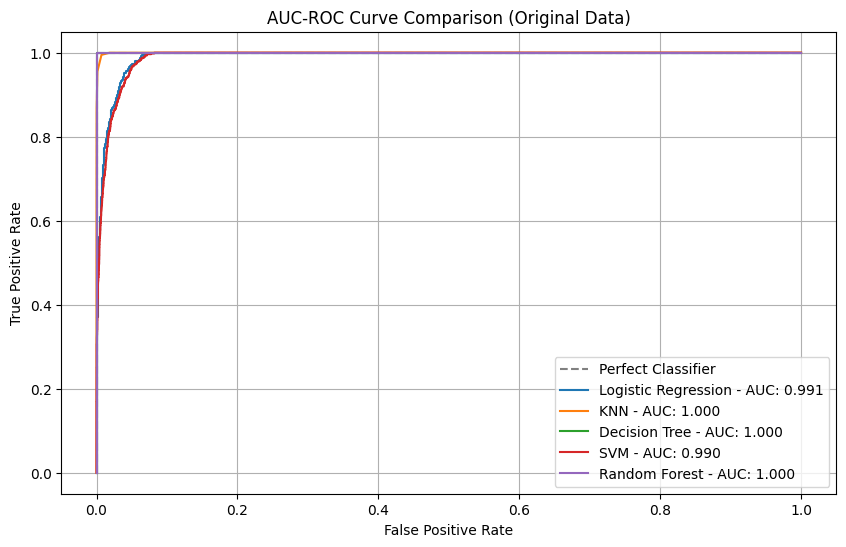

In [64]:
# === 8. Run All Models (Original Data) ===
plt.figure(figsize=(10, 6))

# Plot perfect classifier
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', color='grey', label='Perfect Classifier')

# Loop through models
for name, model in models.items():
    model.fit(X, y)
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_score)
    auc = roc_auc_score(y, y_score)
    plt.plot(fpr, tpr, label=f'{name} - AUC: {auc:.3f}')

# Final plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve Comparison (Original Data)')
plt.legend()
plt.grid()
plt.show()

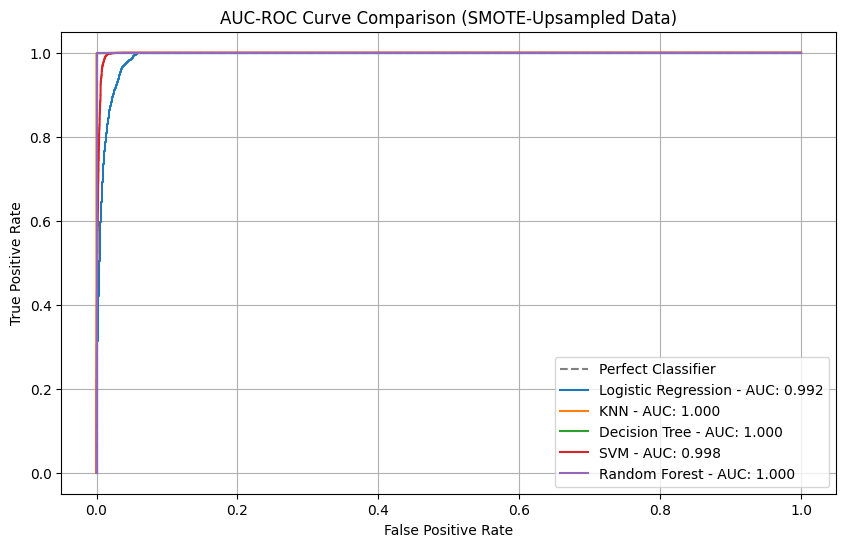

In [65]:
# === 9. Run All Models (SMOTE Data) ===
plt.figure(figsize=(10, 6))

# Plot perfect classifier
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', color='grey', label='Perfect Classifier')

# Loop through models on upsampled data
for name, model in models.items():
    model.fit(X_train_upsample, y_train_upsample)
    y_score = model.predict_proba(X_train_upsample)[:, 1]
    fpr, tpr, _ = roc_curve(y_train_upsample, y_score)
    auc = roc_auc_score(y_train_upsample, y_score)
    plt.plot(fpr, tpr, label=f'{name} - AUC: {auc:.3f}')

# Final plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve Comparison (SMOTE-Upsampled Data)')
plt.legend()
plt.grid()
plt.show()

In [66]:
# === 10. Summary Table ===
summary_df = pd.DataFrame({"Original AUC": auc_scores, "SMOTE AUC": auc_scores_upsample})
print("\n=== AUC Score Comparison ===")
print(summary_df)


=== AUC Score Comparison ===
                                Original AUC  SMOTE AUC
Logistic Regression (original)      0.992379        NaN
KNN (original)                      0.964974        NaN
Decision Tree (original)            1.000000        NaN
SVM (original)                      0.993876        NaN
Random Forest (original)            1.000000        NaN
Logistic Regression (SMOTE)              NaN   0.992911
KNN (SMOTE)                              NaN   0.971957
Decision Tree (SMOTE)                    NaN   1.000000
SVM (SMOTE)                              NaN   0.995607
Random Forest (SMOTE)                    NaN   1.000000


<br>
<div class="alert alert-block alert-info">
Important to mention that I faced some challenges to understando how top plot the ROC AUC, then it was done with the help of AI.


Later, I'll review the code and do it in my own way.
</div>
<br>